In [ ]:
!pip install simpy tqdm
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from tqdm.notebook import tqdm as log_progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Pregress bar

In [ ]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


In [ ]:
# minimum call time is 1 minute 
NUM_EMPLOYEES = 5 # Number of employees suporting 
AVG_SUPPORT_TIME = 5 # Average time to support a client 
CUSTOMER_INTERVAL = 5 # how many call a minute
SIM_TIME = 8 * 60 # Day work 7 hours * 60 minutes  
customers_handled = 0

In [ ]:
class CallCenter:

  def __init__(self, env, staff, support_time):
    self.env = env
    self.staff = simpy.Resource(env, staff)
    self.support_time = support_time

  def support(self, customer):
    random_time = max(1, np.random.normal(self.support_time, 4))
    yield self.env.timeout(random_time)
    print(f"Support finished for {customer} at {self.env.now:.2f}")
  
def customer(env, name, call_center):
  global customers_handled
  print(f"Customer {name} enters waiting queue at {env.now:.2f}")
  with call_center.staff.request() as request:
    yield request
    print(f"Customer {name} enters call at {env.now:.2f}")
    yield env.process(call_center.support(name)) 
    print(f"Customer {name} left call at {env.now:.2f}")
    customers_handled += 1

def setup(env, num_employees, support_time, customer_interval):
  call_center = CallCenter(env, num_employees, support_time) 

  for i in range(1, 6):
    env.process(customer(env, i, call_center))

  while True:
    yield env.timeout(random.randint(customer_interval - 1, customer_interval + 1))
    i+= 1
    env.process(customer(env, num_employees, call_center))

print("Starting Call Center Simulation")
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES, AVG_SUPPORT_TIME, CUSTOMER_INTERVAL))
env.run(until=SIM_TIME)

print("Customer handled: ", str(customers_handled))

Starting Call Center Simulation
Customer 1 enters waiting queue at 0.00
Customer 2 enters waiting queue at 0.00
Customer 3 enters waiting queue at 0.00
Customer 4 enters waiting queue at 0.00
Customer 5 enters waiting queue at 0.00
Customer 1 enters call at 0.00
Customer 2 enters call at 0.00
Customer 3 enters call at 0.00
Customer 4 enters call at 0.00
Customer 5 enters call at 0.00
Support finished for 2 at 1.00
Support finished for 3 at 1.00
Support finished for 4 at 1.00
Support finished for 5 at 1.00
Customer 2 left call at 1.00
Customer 3 left call at 1.00
Customer 4 left call at 1.00
Customer 5 left call at 1.00
Support finished for 1 at 1.31
Customer 1 left call at 1.31
Customer 5 enters waiting queue at 4.00
Customer 5 enters call at 4.00
Customer 5 enters waiting queue at 10.00
Customer 5 enters call at 10.00
Support finished for 5 at 10.22
Customer 5 left call at 10.22
Support finished for 5 at 11.00
Customer 5 left call at 11.00
Customer 5 enters waiting queue at 15.00
Cust

In [ ]:
# Without prints
class CallCenter:

  def __init__(self, env, staff, support_time):
    self.env = env
    self.staff = simpy.Resource(env, staff)
    self.support_time = support_time

  def support(self, customer):
    random_time = max(1, np.random.normal(self.support_time, 4))
    yield self.env.timeout(random_time)
  
def customer(env, name, call_center):
  global customers_handled
  with call_center.staff.request() as request:
    yield request
    yield env.process(call_center.support(name)) 
    customers_handled += 1

def setup(env, num_employees, support_time, customer_interval):
  call_center = CallCenter(env, num_employees, support_time) 

  for i in range(1, 6):
    env.process(customer(env, i, call_center))

  while True:
    yield env.timeout(random.randint(customer_interval - 1, customer_interval + 1))
    i+= 1
    env.process(customer(env, num_employees, call_center))

env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES, AVG_SUPPORT_TIME, CUSTOMER_INTERVAL))
env.run(until=SIM_TIME)

In [ ]:
def average_support_time(customers_handled_avg):
  return sum(customers_handled_avg) / len(customers_handled_avg)

Lets make some analysis

In [ ]:
NUM_EMPLOYEES = 19 # Number of employees suporting 
AVG_SUPPORT_TIME = 5 # Average time to support a client 
CUSTOMER_INTERVAL = 1 # how many call a minute
SIM_TIME = 8 * 60 # Day work 7 hours * 60 minutes  
customers_handled = 0
customers_handled_dict = {} # number employees and the average customer handled

for emploees in log_progress(range(1, 20, 1),1):
  customers_handled_avg = []
  for num in range(1, 5, 1):
    customers_handled = 0
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES, AVG_SUPPORT_TIME, CUSTOMER_INTERVAL))
    env.run(until=SIM_TIME)
    customers_handled_avg.append(customers_handled)
    customers_handled_dict[f"emploees {emploees}"] = average_support_time(customers_handled_avg)

In [ ]:
customer_served_by_employees = pd.DataFrame(customers_handled_dict, index=[0])
customer_served_by_employees

,emploees 1,emploees 2,emploees 3,emploees 4,emploees 5,emploees 6,emploees 7,emploees 8,emploees 9,emploees 10,emploees 11,emploees 12,emploees 13,emploees 14,emploees 15,emploees 16,emploees 17,emploees 18,emploees 19
0,480.5,479.5,483.5,466.5,483.0,483.0,462.5,473.25,475.0,479.75,484.0,483.0,493.75,480.0,479.25,491.5,474.5,482.25,483.0


In [ ]:
AVG_SUPPORT_TIME = 5 # Average time to support a client 
SIM_TIME = 8 * 60 # Day work 8 hours * 60 minutes  

customers_handled = 0
 # number employees and the average customer handled
customer_intervals = {}
intervals = {}
iterations = 1000
max_workers = 100
max_interval = 20

for interval in log_progress(range(1, max_interval, 1), 1):
  customers_handled_dict = {}
  for emploees in range(1, max_workers, 1):
    customers_handled_avg = []
    for num in range(1, iterations, 1):
      customers_handled = 0
      env = simpy.Environment()
      env.process(setup(env, emploees, AVG_SUPPORT_TIME, interval))
      env.run(until=SIM_TIME)
      customers_handled_avg.append(customers_handled)
      customers_handled_dict[f"emploees {emploees}"] = average_support_time(customers_handled_avg)
  intervals[f'{interval}'] = customers_handled_dict


In [ ]:
results = pd.DataFrame(intervals)
results.T

,emploees 1,emploees 2,emploees 3,emploees 4,emploees 5,emploees 6,emploees 7,emploees 8,emploees 9,emploees 10,...,emploees 90,emploees 91,emploees 92,emploees 93,emploees 94,emploees 95,emploees 96,emploees 97,emploees 98,emploees 99
1,89.729730,179.442442,269.117117,358.049049,442.695696,475.983984,478.533534,479.390390,478.208208,479.164164,...,479.426426,479.493493,480.217217,478.694695,480.835836,479.559560,479.453453,478.979980,479.506507,479.097097
2,89.567568,179.140140,240.180180,241.888889,241.494494,241.930931,241.764765,241.739740,241.714715,241.906907,...,241.884885,242.054054,241.883884,242.152152,241.849850,241.738739,241.622623,241.788789,242.063063,241.974975
3,89.702703,161.324324,162.572573,162.806807,162.806807,162.741742,162.771772,162.836837,162.785786,162.779780,...,162.657658,162.639640,162.598599,162.595596,162.617618,162.739740,162.602603,162.787788,162.756757,162.795796
4,90.017017,123.078078,123.212212,123.160160,123.166166,123.285285,123.085085,123.145145,123.188188,123.174174,...,123.176176,123.211211,123.191191,123.180180,123.273273,123.126126,123.269269,123.224224,123.236236,123.196196
5,89.141141,99.317317,99.466466,99.367367,99.460460,99.372372,99.399399,99.464464,99.455455,99.389389,...,99.384384,99.444444,99.500501,99.415415,99.436436,99.472472,99.425425,99.352352,99.444444,99.480480
6,82.275275,83.597598,83.594595,83.626627,83.647648,83.602603,83.622623,83.644645,83.608609,83.569570,...,83.545546,83.618619,83.584585,83.615616,83.636637,83.665666,83.611612,83.634635,83.666667,83.637638
7,71.980981,72.261261,72.360360,72.339339,72.299299,72.297297,72.311311,72.329329,72.323323,72.320320,...,72.271271,72.371371,72.256256,72.345345,72.293293,72.300300,72.292292,72.294294,72.319319,72.285285
8,63.723724,63.814815,63.790791,63.840841,63.864865,63.845846,63.841842,63.812813,63.862863,63.803804,...,63.786787,63.846847,63.787788,63.831832,63.816817,63.769770,63.790791,63.796797,63.850851,63.840841
9,57.162162,57.218218,57.228228,57.233233,57.227227,57.209209,57.242242,57.245245,57.259259,57.236236,...,57.275275,57.251251,57.263263,57.220220,57.237237,57.260260,57.238238,57.256256,57.236236,57.256256
10,51.943944,51.936937,51.933934,51.982983,51.944945,51.995996,51.968969,51.947948,51.962963,51.962963,...,51.972973,51.950951,51.942943,51.940941,51.966967,51.966967,51.936937,51.974975,51.927928,51.997998


In [ ]:
results.to_csv("results_support_20_min.csv")

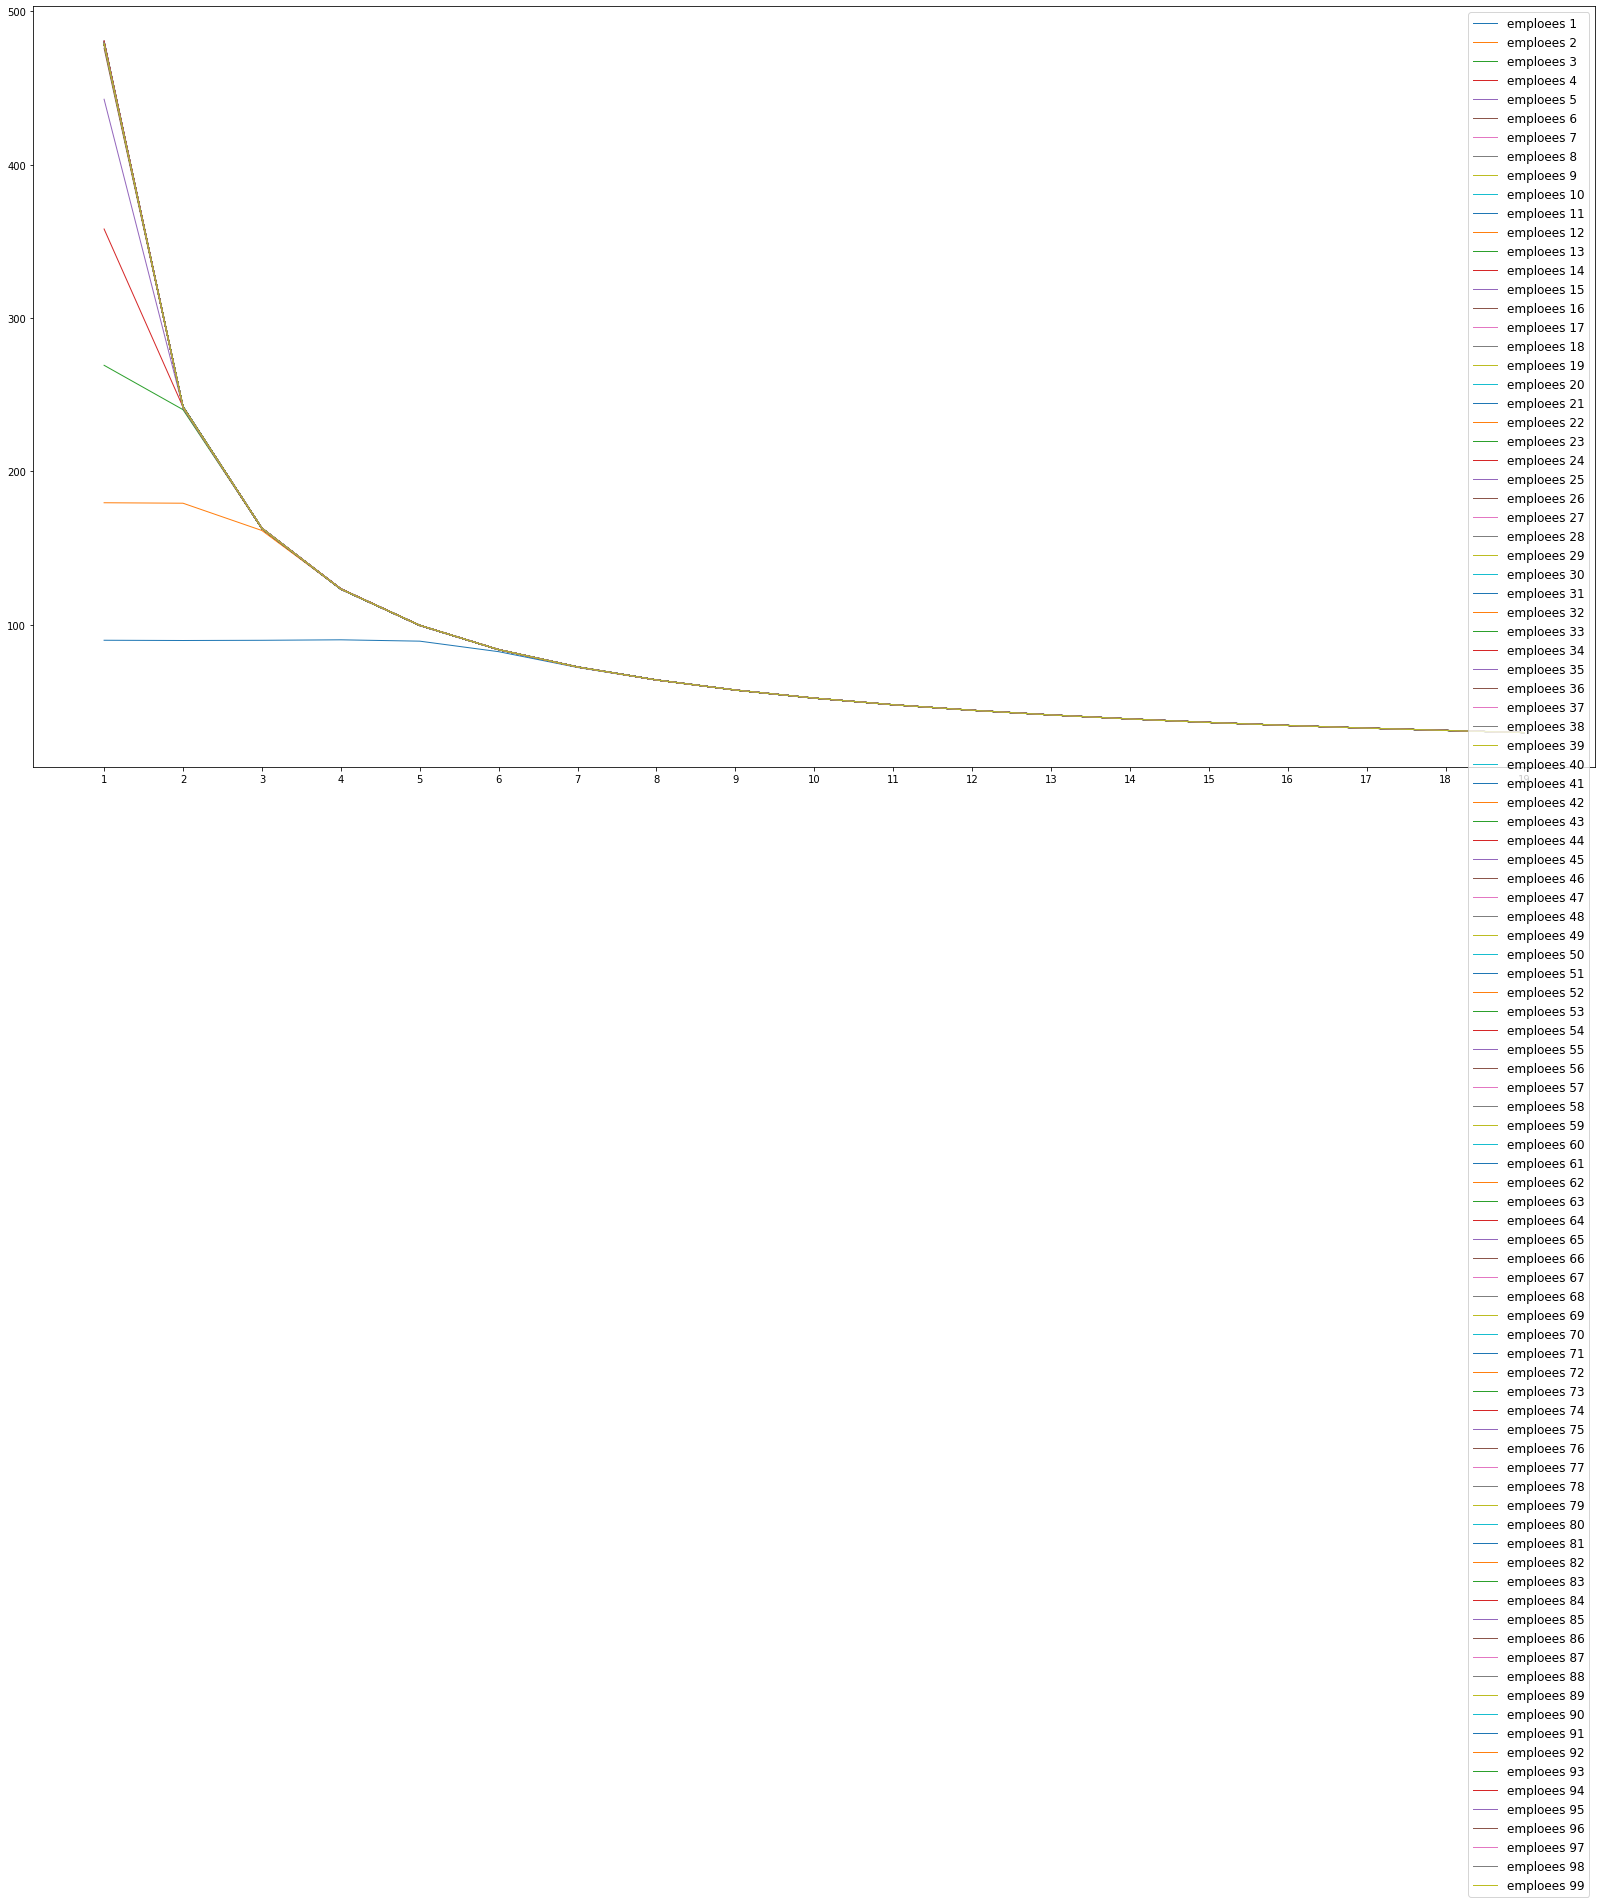

In [ ]:
def graph_stocks(results):
  #graph all stocks
  plt.figure(figsize=(28, 14))
  for c in results.columns.values:
    #print(c)
    fig = plt.plot(results.index, results[c], lw=1, alpha=1)
  plt.legend(results.columns, fontsize=12)
  #plt.ylabel('price in $')
#remove axis labels
  plt.gca().axes.get_yaxis().set_visible(True)
graph_stocks(results.T)